# The Transformation and Accept/Reject (aka. Von Neumann) methods 
Python notebook with exercise on how to generate random numbers following a specific PDF using uniformly distributed random numbers, in this case a third degree polynomial: $f(x) = x^3$, in the interval $[0, C]$ where $C$ is a number that ensures that the function if properly normalized.

Both the Accept-Reject (Von Neumann) and transformation method should be considered for the problem:
- Transformation method (if function can be integrated and then inverted).
- Accept-Reject (or Hit & Miss) method (by Ulam Stanislav and John Von Neumann).

### References:
- G. Cowan: Chapter 3
- P. R. Bevington: page 81-84
- __[40. Monte Carlo Techniques PDG](https://pdg.lbl.gov/2023/reviews/rpp2023-rev-monte-carlo-techniques.pdf)__

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 30-11-2025 (latest update)

***

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats
plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

set the parameters of the program:

In [32]:
r = np.random
r.seed(42)

save_plots = False  
N_points = 10000      # Number of random points used 

xmin = 0
xmax = 1.0            # Find out yourself what a good interval is.
N_bins = 100          # Find out yourself what a good number of bins is.

# f(x):
def fx_x3(x) :
    k = (xmax - xmin) / N_bins
    N = N_points * k
    return N*x**3

integral: $F(x) = \frac{1}{4} x^4 - (1/4 (-\inf)^4)$

In [33]:
# Define the numpy arrays to be filled:
x_transformation = np.zeros(N_points)
x_accepted       = np.zeros(N_points)

In [34]:
x_transformation = (4*r.uniform(size=N_points))**(1/4)

## Transformation method

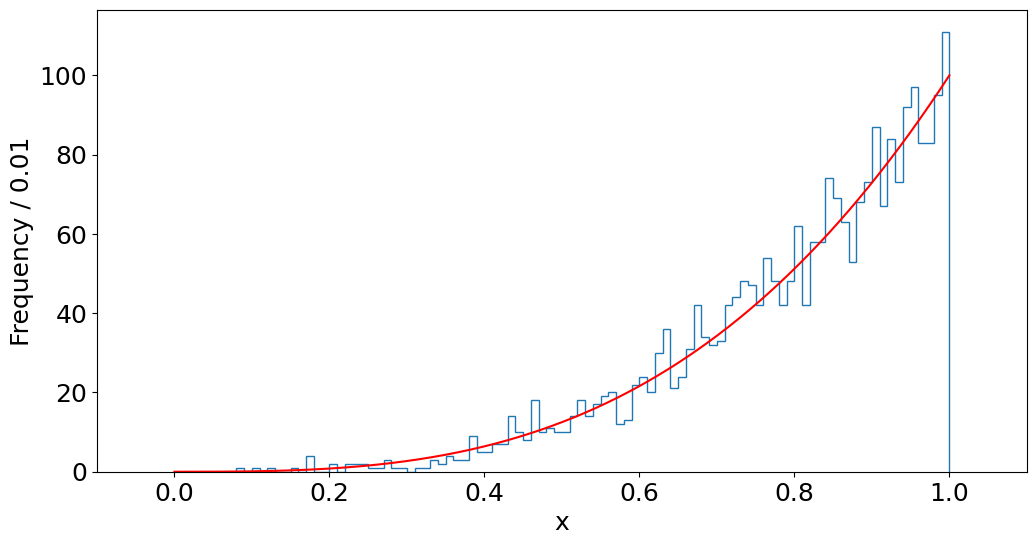

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(x_transformation, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )
x_axis1 = np.linspace(xmin, xmax, 1000)
y_axis1 = fx_x3(x_axis1)
ax.plot(x_axis1, y_axis1, 'r-', label='function (not fitted)')
ax.set(xlabel="x", ylabel="Frequency / 0.01", xlim=(xmin-0.1, xmax+0.1));

## Accept/reject method

In [36]:
N_try = 0
ymin = 0.0      # Minimum value the function will take!
ymax = xmax     # Maximum value the function will take!
x_accepted = np.zeros(N_points)

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try += 1                    
        
        # Range that f(x) is defined/wanted in:
        x_test = r.uniform(xmin, xmax)  
        
        # Upper bound for function values:
        y_test = r.uniform(ymin, ymax)
        
        if (y_test < x_test**3):
            break
            
    x_accepted[i] = x_test

In [37]:
# Efficiency
eff = N_points / N_try                        

# Error on efficiency (binomial!)
eff_error = np.sqrt(eff * (1-eff) / N_try) 

# Integral
integral =  eff * (xmax-xmin) * (ymax-ymin)

# Error on integral
eintegral = eff_error * (xmax-xmin) * (ymax-ymin)  

print(f"\nIntegral of f(x) = 2x, x in [0, 1] is: \t {integral:7.4f} +- {eintegral:6.4f}")
print(f"The efficiency of the Accept/Reject method used here is: \t {eff:.2%} +/- {eff_error:.2%}")
# We normalized the function ahead of time, so we should hope to get a result consistent with unity!


Integral of f(x) = 2x, x in [0, 1] is: 	  0.2514 +- 0.0022
The efficiency of the Accept/Reject method used here is: 	 25.14% +/- 0.22%


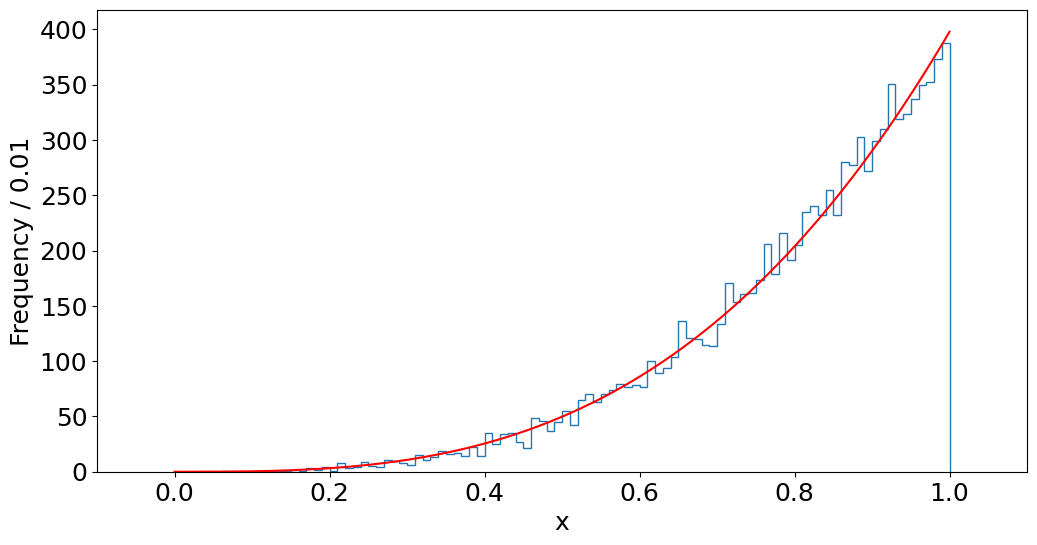

In [38]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.hist(x_accepted, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )
x_axis2 = np.linspace(xmin, xmax, 1000)
y_axis2 = fx_x3(x_axis2) *N_try / N_points
ax2.plot(x_axis2, y_axis2, 'r-', label='function (not fitted)')

ax2.set(xlabel="x", ylabel="Frequency / 0.01", xlim=(xmin-0.1, xmax+0.1));

In [45]:

# Define polynomial model (returns predicted counts per bin)
def poly3_counts(x, a0, a1, a2, a3):
    return a0 + a1*x + a2*x**2 + a3*x**3

# Histogram the two samples using same bins
# bin_edges = np.linspace(xmin, xmax, N_bins+1)
# xcenters = 0.5*(bin_edges[:-1] + bin_edges[1:])

# h_trans, _ = np.histogram(x_transformation, bins=bin_edges)
# h_acc,   _ = np.histogram(x_accepted,       bins=bin_edges)

counts, bin_edges = np.histogram(x_transformation, bins=N_bins,range=(xmin, xmax))

x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
mask = y > 0
x = x[mask]
y = y[mask].astype(float)
sy = np.sqrt(counts)
sy = sy[mask]


In [46]:
Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)


# Alternatively, use the Chi2 regression from External Functions:
cfit = cost.LeastSquares(x, y, sy, poly3_counts)

# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

mfit = Minuit(cfit, a0=0, a1=0, a2=0, a3=1)  # Starting values for parameters
mfit.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 71.16 (χ²/ndof = 0.9)      │              Nfcn = 96               │
│ EDM = 2.84e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a0   │    3.8    │    1.4    │            │            │         │         │       │
│ 1 │ a1   │    -30    │    13     │            │            │         │         │       │
│ 2 │ a2   │    57     │    33     │            │            │         │         │       │
│ 3 │ a3   │    69     │    24     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────┐
│    │      a0      a1      a2      a3 │
├────┼─────────────────────────────────┤
│ a0 │    1.98   -16.8    39.9   -26.9 │
│ a1 │   -16.8     160 -0.41e3  0.29e3 │
│ a2 │    39.9 -0.41e3 1.1e+03  -0.8e3 │
│ a3 │   -26.9  0.29e3  -0.8e3     602 │
└────┴─────────────────────────────────┘

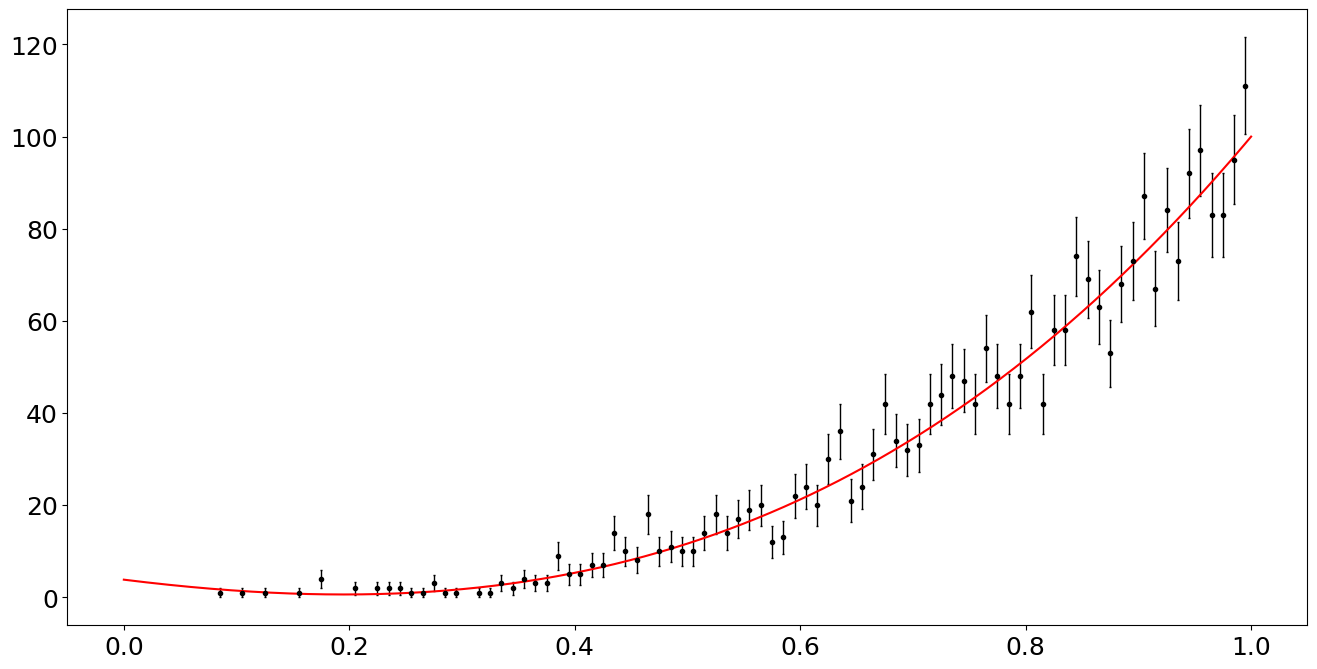

In [47]:
fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
x_axis = np.linspace(xmin, xmax, 1000)
ax.plot(x_axis, poly3_counts(x_axis, *mfit.values[:]), '-r', label= r"Chi2 fit model result") 


Fit results for transformation:
 a0 = 3.81679 ± 1.40541
 a1 = -30.2301 ± 12.6525
 a2 = 57.1968 ± 33.2307
 a3 = 69.2046 ± 24.5409
 chi2 = 71.16, ndof = 79, p = 0.723

Fit results for accept/reject:
 a0 = 2.79551 ± 1.66461
 a1 = -25.9956 ± 17.1048
 a2 = 37.0097 ± 48.7257
 a3 = 388.584 ± 38.1018
 chi2 = 91.19, ndof = 84, p = 0.277


c:\Users\villa\Desktop\AppStat25\.venv\Lib\site-packages\iminuit\minuit.py:149: ErrordefAlreadySetWarning: cost function has an errordef attribute equal to 1.0, you should not override this with Minuit.errordef
  warnings.warn(msg, ErrordefAlreadySetWarning)


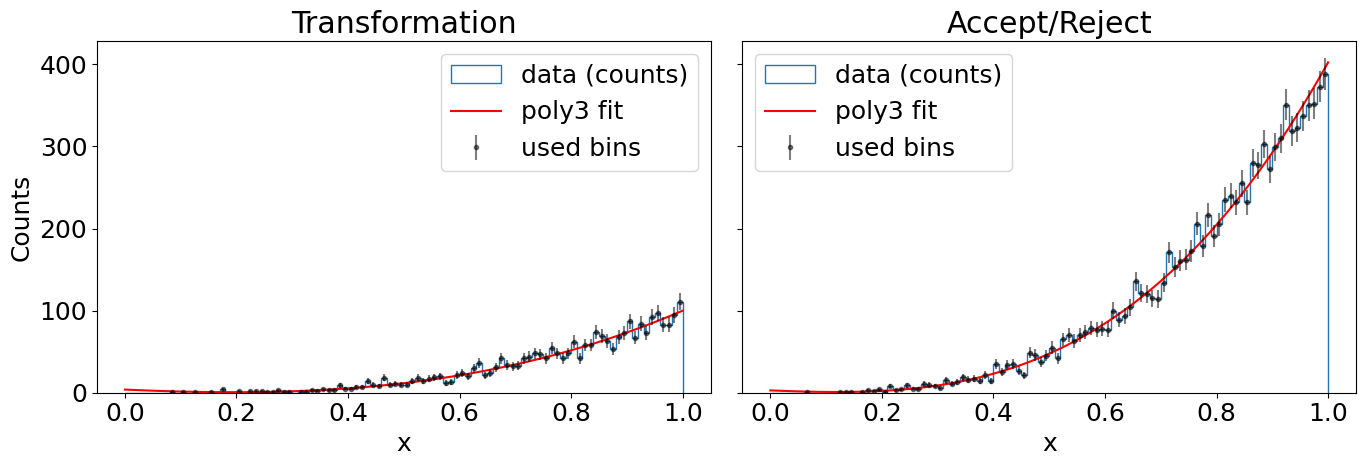

In [42]:
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats

# Define polynomial model (returns predicted counts per bin)
def poly3_counts(x, a0, a1, a2, a3):
    return a0 + a1*x + a2*x**2 + a3*x**3

# Histogram the two samples using same bins
# bin_edges = np.linspace(xmin, xmax, N_bins+1)
# xcenters = 0.5*(bin_edges[:-1] + bin_edges[1:])

# h_trans, _ = np.histogram(x_transformation, bins=bin_edges)
# h_acc,   _ = np.histogram(x_accepted,       bins=bin_edges)

counts, bin_edges = np.histogram(x_transformation, bins=N_bins,range=(xmin, xmax))

x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)






def fit_hist(h, label):
    # mask bins with zero counts to avoid sy=0
    mask = h > 0
    x = xcenters[mask]
    y = h[mask].astype(float)
    sy = np.sqrt(y)            # Poisson uncertainty on counts

    # build LeastSquares cost
    cfit = cost.LeastSquares(x, y, sy, poly3_counts)

    # initial guesses (use shape of x^3 as rough guide)
    init = dict(a0=0.0, a1=0.0, a2=0.0, a3= (y.max()/(x.max()**3) if x.size and x.max()>0 else 1.0))

    m = Minuit(cfit, **init)
    m.limits['a3'] = (None, None)  # no strict limits; adjust if you want
    m.errordef = 1.0   # LeastSquares uses errordef=1.0
    m.migrad()
    m.hesse()

    params = m.values
    errors = m.errors

    # compute chi2 and p-value on the used bins
    y_pred = poly3_counts(x, params['a0'], params['a1'], params['a2'], params['a3'])
    chi2 = np.sum(((y - y_pred) / sy) ** 2)
    ndof = max(1, x.size - len(params))
    pval = stats.chi2.sf(chi2, ndof)

    print(f"\nFit results for {label}:")
    for name in ['a0','a1','a2','a3']:
        print(f" {name} = {params[name]:.6g} ± {errors[name]:.6g}")
    print(f" chi2 = {chi2:.2f}, ndof = {ndof}, p = {pval:.3g}")

    # return for plotting
    return params, errors, x, y, sy

# Fit both datasets
res_trans = fit_hist(h_trans, "transformation")
res_acc   = fit_hist(h_acc,   "accept/reject")

# Plot histograms and fits
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True)
for subplot, (h, title, res) in enumerate([(h_trans, "Transformation", res_trans),
                                           (h_acc,   "Accept/Reject",  res_acc)]):
    params, errors, x_fit, y_fit, sy_fit = res
    ax[subplot].hist(xcenters, bins=bins, weights=h, histtype='step', label='data (counts)')
    xplot = np.linspace(xmin, xmax, 500)
    yplot = poly3_counts(xplot, params['a0'], params['a1'], params['a2'], params['a3'])
    ax[subplot].plot(xplot, yplot, 'r-', label='poly3 fit')
    ax[subplot].errorbar(x_fit, y_fit, yerr=sy_fit, fmt='.', color='k', alpha=0.5, label='used bins')
    ax[subplot].set_title(title)
    ax[subplot].set_xlabel('x')
    ax[subplot].legend()
ax[0].set_ylabel('Counts')
plt.tight_layout()
plt.show()
# ...existing code...

## Problem: 

1) Calculate $C$ such that f(x) is normalised [Analytical problem].

2) Calculate the relevant integral (below) and inverted function for using the transformation method. Check that the limits actually makes sense [Analytical problem]. Note that it is important to include the limits!

$$F(x) = \int_{-\infty}^{x} f(x') dx'$$

3) Produce random points following $f(x) = x^3$, in the interval $[0, C]$ using **both** the Transformation and the Accept/Reject method.

4) Fit your data with a third degree polynomial, and check that the coefficients correspond to what you would expect.

5) Now try to change the interval from [0,C] to [1,C], and see how the limits change.

# Learning points:

As a basic principle, this exercise should make you capable of using two methods for generating random numbers according to a 1D PDF f(x) based on uniform random numbers (provided by a standard algorithm):
1. Transformation method (using integral+inverse of f(x))
2. Accept-Reject method (using sampling in 2D compared to f(x))

You should know:
1. The advantages and limitations of each method.
2. How to get the desired result out of each method.

Finally, you should understand the motivation behind generating random numbers according to a given distribution, namely for simulating complicated situations (e.g. experimental setup), and evaluating the outcome.